In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, Permute, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
/Users/raymond.djajalaksana/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

class DDPGEnvProcessor(EnvProcessor):
    def __init__(self, train_policy, test_policy):
        EnvProcessor.__init__(self)
        self.nb_act_count = [0,0]
        self.count = 0
        self.train_policy = train_policy
        self.test_policy = test_policy
        
    def process_action(self,actions):
        if self.is_train:
            choice = self.train_policy.select_action(q_values=actions)
        else:
            choice = self.test_policy.select_action(q_values=actions)
        self.nb_act_count[choice] +=1
        self.count += 1
        if self.count % 1949 == 0:
            print(self.nb_act_count)
        if self.count % 400 == 0:
            print(actions)
            
        return choice
    def train_mode(self, is_train=True):
        self.is_train = is_train

In [47]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 4500), window_size=window_size)

window_size = 25
env = env_creator()
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = env.action_space.n
    env_shape = (window_size,2)
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

def critic_actor():
    env_shape = (window_size,2)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(32, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('softmax')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
#     train_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.08, value_test=0.05, nb_steps=10000)
#     test_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.00, value_min=0.00, value_test=0.00, nb_steps=10000)
    train_policy = BoltzmannQPolicy()
    test_policy = BoltzmannQPolicy()
    processor = DDPGEnvProcessor(train_policy,test_policy)
    processor.train_mode(True)
    memory = SequentialMemory(limit=128, window_length=1)
    actor, critic, action_input = critic_actor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                      random_process=random_process,processor=processor, gamma=1.0, 
                      batch_size=32, train_interval=32)
    agent.compile((Adam(lr=0.002),Adam(lr=0.002)), metrics=['mae'])
    train_policy._set_agent(agent)
    test_policy._set_agent(agent)
    return agent

['loss', 'mean_absolute_error', 'mean_q']
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
889/889 [==============================] - 54s 61ms/step - reward: 1.0659 - cumulative_reward: 764.8872

train 1 completed. total_reward: 948.4000000000394 total_profit: 0.7164470003908818
min reward: -79.69999999999811, max reward: 181.00000000000006, mean_reward: 0.2131714992133152

['loss', 'mean_absolute_error', 'mean_q']
starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
889/889 [==============================] - 57s 64ms/step - reward: 10.7280 - cumulative_reward: 299.1258

train 2 completed. total_reward: 647.8000000001224 total_profit: 0.7187922493105917
min reward: -168.70000000000164, max reward: 129.69999999999925, mean_reward: 0.1456057541020729

['loss', 'mean_absolute_error', 'mean_q']
starting train 3
-----------

889/889 [==============================] - 61s 68ms/step - reward: -6.9996 - cumulative_reward: 124.9134

train 4 completed. total_reward: -177.59999999989614 total_profit: 0.6817302526222312
min reward: -154.50000000000185, max reward: 149.49999999999795, mean_reward: -0.03991908293996317

['loss', 'mean_absolute_error', 'mean_q']
starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
889/889 [==============================] - 60s 67ms/step - reward: -0.2238 - cumulative_reward: -381.1851

train 5 completed. total_reward: -1266.8999999999398 total_profit: 0.6624132038818812
min reward: -168.70000000000164, max reward: 87.99999999999919, mean_reward: -0.28476062036411326

average rewards: -44.899999999904274
best reward: 948.4000000000394


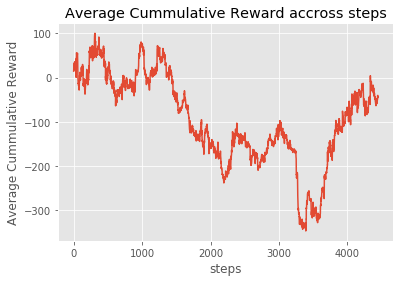

In [48]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=5)
e.process_train_result()

In [49]:
def test(repeat = 1):
    reward = []
    profit = []
    for i in range(repeat):
        env_test = gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size)
        e.agent.test(env_test, visualize=False)
        reward.append(env_test._total_reward)
        profit.append(env_test._total_profit)
        env_test.render_all()
    print("average rewards : {}".format(np.mean(reward)))
    print("average rewards : {}".format(np.mean(profit)))

Testing for 1 episodes ...
[0.44159403 0.5584059 ]
[0.37720203 0.6227979 ]
Episode 1: reward: -296.300, steps: 999
Testing for 1 episodes ...
[0.14757062 0.85242945]
[2276, 3571]
[0.20649154 0.79350847]
[0.6552274  0.34477264]
Episode 1: reward: 124.500, steps: 999
Testing for 1 episodes ...
[0.21655191 0.78344816]
[0.09188258 0.9081175 ]
Episode 1: reward: -315.100, steps: 999
Testing for 1 episodes ...
[0.3524541  0.64754593]
[3080, 4716]
[0.10099649 0.8990035 ]
[0.11581339 0.88418657]
Episode 1: reward: -273.900, steps: 999
Testing for 1 episodes ...
[0.20817243 0.79182756]
[0.46605805 0.5339419 ]
Episode 1: reward: 319.600, steps: 999
average rewards : -88.24000000002513
average rewards : 0.9390773312899189


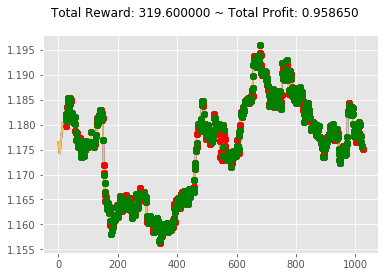

In [50]:
test(repeat=5)